# SLC

## Imports

In [1]:
import os
from datetime import datetime
import inspect
import gc
import math
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import ndimage
import scipy.io as sio
import torch
import torch.optim as optim
import torch.nn as nn
import itertools
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.functional import dice, jaccard_index
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
#from tqdm import tqdm
from tqdm.notebook import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms

import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())

Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Functions

### Load .nc images

In [2]:
def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  

### Save training information


In [3]:

def get_model_summary(model, input_size):
    return str(summary(model, input_size=input_size))

# Get the model code
def get_model_code(model):
    return str(model)

#Get training output
def get_training_output(training_log):
    return str(training_log)

def save_training_info(model, configs, training_log, best_val_acc):
    now = datetime.now()
    date_time_str = now.strftime("%d_%m_%H_%M")
    file_name = f"{date_time_str}_acc_{best_val_acc:.4f}.txt"

    experiments_dir = "C:\\WaveSeg\\experiments"  # Use the full path
    if not os.path.exists(experiments_dir):
        os.makedirs(experiments_dir)    

    file_path = os.path.join(experiments_dir, file_name)  # Construct the full file path

    with open(file_path, "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(f"DATE: {now.strftime('%d/%m/%Y %H:%M')}\n")
        f.write(f"MODEL ACCURACY: {best_val_acc:.4f}\n\n")

        f.write("CONFIGURATIONS:\n\n")
        for key, value in configs.items():
            f.write(f"{key} = {value}\n")

        f.write("\nTRAINING OUTPUT:\n\n")
        # Modified part: Write each line from training_log separately
        for line in training_log:
            f.write(line + "\n")

        f.write("\n\nMODEL SUMMARY:\n\n")
        # Assuming an input size for the summary.  Adjust as needed.
        input_size = (1, configs['num_components'], configs['PATCH_SIZE'], configs['PATCH_SIZE'])
        f.write(get_model_summary(model, input_size))

        f.write("\n\nMODEL CODE:\n\n")
        f.write(get_model_code(model))



### Dimensionality Reduction (PCA)

In [4]:
def batch_processing(files, num_pca_components=None, batch_size=4, processing_type="pca"):
    processed_images = []
    total_batches = math.ceil(len(files) / batch_size)

    with tqdm(total=len(files), desc=f"Processing {processing_type.upper()} for images", unit="image") as pbar:
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(files))
            batch_files = files[start_idx:end_idx]

            batch_results = []
            for img in batch_files:
                reshaped_data = img.reshape(-1, img.shape[-1])  # Flatten for PCA

                if processing_type == "pca":
                    pca = PCA(n_components=num_pca_components)
                    transformed_data = pca.fit_transform(reshaped_data)

                elif processing_type == "none":
                    transformed_data = reshaped_data  # No transformation

                # Reshape back to original (H, W, C) format
                num_components = transformed_data.shape[1]
                transformed_data = transformed_data.reshape(img.shape[0], img.shape[1], num_components)

                batch_results.append(transformed_data)
                pbar.update(1)

            processed_images.extend(batch_results)
            gc.collect()  # Free memory

    return np.array(processed_images)


### Patch Extraction

In [5]:
def apply_padding(image, patch_size, stride, mode='reflect'):
    height, width, channels = image.shape

    # Calculate padding needed
    pad_h = (patch_size - (height % stride)) % patch_size
    pad_w = (patch_size - (width % stride)) % patch_size

    # Apply padding to height and width
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode=mode)

    return padded_image

def extract_patches(image, patch_size, stride):
    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []
    indices = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            indices.append((i, j))

    return np.array(patches), indices



class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=None, stride=None, is_pred=False):
        self.images = images
        self.labels = labels
        self.patch_size = patch_size
        self.stride = stride
        self.is_pred = is_pred
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        self.image_to_patch_map = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            img_patches = []
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
        self.total_patches = len(self.patch_indices)
                    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        if not self.is_pred and self.labels is not None:
            label = self.labels[img_idx]
            label_patch = label[i:i+patch_size, j:j+patch_size]
            label_tensor = torch.tensor(label_patch, dtype=torch.long)
            return patch_tensor, label_tensor
        
        return patch_tensor

    
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=None, stride=None):
        self.images = images
        self.patch_size = patch_size
        self.stride = stride
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        return patch_tensor, img_idx
    
def reconstruct_image_with_confidence(patches, confidence_scores, original_shape, patch_size=None, stride=None):
    
    H, W = original_shape
    reconstructed = np.zeros((H, W), dtype=np.float32)
    weights = np.zeros((H, W), dtype=np.float32)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            # Add weighted vote for each pixel
            patch_pred = patches[patch_idx]
            patch_conf = confidence_scores[patch_idx]
            
            reconstructed[i:i+patch_size, j:j+patch_size] += patch_pred * patch_conf
            weights[i:i+patch_size, j:j+patch_size] += patch_conf
            
            patch_idx += 1

    # Normalize by weights
    mask = weights > 0
    reconstructed[mask] = reconstructed[mask] / weights[mask]
    
    # Round to nearest integer for class labels
    return np.round(reconstructed).astype(np.uint8)



### Model saving

In [6]:
# Saves only model from best epoch and moves previous trained models to experiments folder.

def get_best_model(acc_list, epoch_list, save_path):
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list == np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"{datetime.now().strftime('%d_%m_%H_%M')}_acc_{best_acc:.4f}_EPOCH_{best_epoch}.pth"  
    best_model_path = os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    experiments_dir = "C:\\WaveSeg\\experiments" 
    previous_best_model = None
    for f in os.listdir(save_path):
        if f.endswith('.pth') and '_EPOCH_' in f and f != file_name: 
            if previous_best_model is None:
                previous_best_model = os.path.join(save_path, f)
            else:
                os.remove(os.path.join(save_path, f)) 
        elif f.endswith('.pth') and '_EPOCH_' not in f and f != file_name: 
            os.remove(os.path.join(save_path, f))
    if previous_best_model:
        new_model_path = os.path.join(experiments_dir, os.path.basename(previous_best_model))
        os.rename(previous_best_model, new_model_path)
        txt_file_name = os.path.splitext(os.path.basename(previous_best_model))[0] + ".txt"
        old_txt_path = os.path.join(save_path, txt_file_name)
        if os.path.exists(old_txt_path):
            new_txt_path = os.path.join(experiments_dir, os.path.basename(txt_file_name))
            os.rename(old_txt_path, new_txt_path)

    return best_model_path


# Loads most recently trained model for inference

def trained_model(acc_list, epoch_list, save_path):
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list == np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]

    best_model_file = None
    for filename in os.listdir(save_path):
        if filename.endswith(f"_acc_{best_acc:.4f}_EPOCH_{best_epoch}.pth"):
            best_model_file = filename
            break

    if best_model_file:
        best_model_path = os.path.join(save_path, best_model_file)
        print(f"best model:{best_model_file}")
        return best_model_path
    else:
        print(f"Error: No matching model file found for accuracy {best_acc:.4f} and epoch {best_epoch} in {save_path}")
        return None  

# Loss function for the training loop

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = torch.nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        

## Files

In [7]:

# l1a.nc and labels.dat files path
hypso2_data_path = r'C:\Users\Philip Shahdadfar\Desktop\H2'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\H2LABELS'


#Lists of captures and corresponding labels to load
hypso2_files = [
    'aeronetgalata_2025-01-02T08-52-34Z-l1a.nc', #0
    'aeronetgloria_2025-01-09T11-17-15Z-l1a.nc', #1
    'aquawatchgrippsland_2025-03-09T00-16-17Z-l1a.nc', #2
    'aquawatchlakehume_2025-03-08T00-09-52Z-l1a.nc', #3
    'aquawatchmoreton_2025-01-22T00-11-33Z-l1a.nc', #4
    'aquawatchspencer_2025-01-03T01-17-50Z-l1a.nc', #5
    'ariake_2025-02-11T02-05-25Z-l1a.nc', #6
    'blanca_2025-02-04T14-31-12Z-l1a.nc', #7
    'bluenile_2025-01-25T08-23-16Z-l1a.nc', #8
    'falklandsatlantic_2025-03-03T14-11-51Z-l1a.nc', #9
    'frohavet_2025-02-25T11-26-39Z-l1a.nc', #10
    'gobabeb_2025-02-02T09-24-52Z-l1a.nc', #11
    'goddard_2025-01-09T16-07-16Z-l1a.nc', #12 
    'grizzlybay_2025-01-22T19-11-18Z-l1a.nc', ### Feil #13 
    'gulfofcalifornia_2025-01-14T18-19-49Z-l1a.nc', #14
    'gulfofcampeche_2025-03-03T17-04-38Z-l1a.nc', #15
    'hypernetEstuary_2024-12-28T11-29-35Z-l1a.nc', #16
    'image61N6E_2025-03-13T11-27-56Z-l1a.nc', #17
    'image65N10E_2025-03-12T11-20-52Z-l1a.nc', #18
    'kemigawa_2025-01-22T01-31-13Z-l1a.nc', #19
    'lacrau_2024-12-26T11-15-54Z-l1a.nc', #20 
    'menindee_2025-01-02T01-10-11Z-l1a.nc', #21
    'moby_2025-01-08T20-54-59Z-l1a.nc', #22
    'mvco_2025-02-05T15-52-26Z-l1a.nc', #23
    'sanjorgegulf_2025-03-08T14-39-52Z-l1a.nc', #24
    'section7platform_2025-02-02T09-06-35Z-l1a.nc', #25
    'sicilychannel_2025-01-10T09-48-59Z-l1a.nc', #26
    'timaru_2025-01-21T22-39-53Z-l1a.nc', #27
    'wilmington_2025-03-08T15-55-06Z-l1a.nc', #28
    'zeebrugge_2025-03-08T11-00-54Z-l1a.nc', #29
]

labels_files =  [
    'aeronetgalata_2025-01-02T08-52-34Z-l1a_labels.dat',
    'aeronetgloria_2025-01-09T11-17-15Z-l1a_labels.dat',
    'aquawatchgrippsland_2025-03-09T00-16-17Z-l1a_labels.dat',
    'aquawatchlakehume_2025-03-08T00-09-52Z-l1a_labels.dat',
    'aquawatchmoreton_2025-01-22T00-11-33Z-l1a_labels.dat',
    'aquawatchspencer_2025-01-03T01-17-50Z-l1a_labels.dat',
    'ariake_2025-02-11T02-05-25Z-l1a_labels.dat',
    'blanca_2025-02-04T14-31-12Z-l1a_labels.dat',
    'bluenile_2025-01-25T08-23-16Z-l1a_labels.dat',
    'falklandsatlantic_2025-03-03T14-11-51Z-l1a_labels.dat',
    'frohavet_2025-02-25T11-26-39Z-l1a_labels.dat',
    'gobabeb_2025-02-02T09-24-52Z-l1a_labels.dat',
    'goddard_2025-01-09T16-07-16Z-l1a_labels.dat',
    'grizzlybay_2025-01-22T19-11-18Z-l1a_labels.dat',
    'gulfofcalifornia_2025-01-14T18-19-49Z-l1a_labels.dat',
    'gulfofcampeche_2025-03-03T17-04-38Z-l1a_labels.dat',
    'hypernetEstuary_2024-12-28T11-29-35Z-l1a_labels.dat',
    'image61N6E_2025-03-13T11-27-56Z-l1a_labels.dat',
    'image65N10E_2025-03-12T11-20-52Z-l1a_labels.dat',
    'kemigawa_2025-01-22T01-31-13Z-l1a_labels.dat',
    'lacrau_2024-12-26T11-15-54Z-l1a_labels.dat',
    'menindee_2025-01-02T01-10-11Z-l1a_labels.dat',
    'moby_2025-01-08T20-54-59Z-l1a_labels.dat',
    'mvco_2025-02-05T15-52-26Z-l1a_labels.dat',
    'sanjorgegulf_2025-03-08T14-39-52Z-l1a_labels.dat',
    'section7platform_2025-02-02T09-06-35Z-l1a_labels.dat',
    'sicilychannel_2025-01-10T09-48-59Z-l1a_labels.dat',
    'timaru_2025-01-21T22-39-53Z-l1a_labels.dat',
    'wilmington_2025-03-08T15-55-06Z-l1a_labels.dat',
    'zeebrugge_2025-03-08T11-00-54Z-l1a_labels.dat',
]

## Settings

In [8]:
data_file = 'h2'

apply_pca = False
N_PCA = 30
BATCH_SIZE = 128
PATCH_SIZE = 16
STRIDE = 4
NUM_CLASS = 3  
WEIGHT_DECAY = 0.0005
LR = 0.0005

TRAIN_SIZE = 0.6         
VALIDATION_SIZE = 0.2
TEST_SIZE = 0.2

EPOCH = 10


MOTHER_WAVELET = 'coif1'
DWT_WAVELET_LEVELS = 1
BASE_CHANNELS = 16
DROPOUT_RATE = 0.3


if apply_pca:
    num_components = N_PCA
else:
    num_components = 120
    N_PCA = None

def get_configurations():
    configs = {}
    configs['data_file'] = data_file
    configs['apply_pca'] = apply_pca
    configs['N_PCA'] = N_PCA
    configs['num_components'] = num_components
    configs['BATCH_SIZE'] = BATCH_SIZE
    configs['PATCH_SIZE'] = PATCH_SIZE
    configs['STRIDE'] = STRIDE
    configs['NUM_CLASS'] = NUM_CLASS
    configs['WEIGHT_DECAY'] = WEIGHT_DECAY
    configs['LR'] = LR
    configs['TRAIN_SIZE'] = TRAIN_SIZE
    configs['VALIDATION_SIZE'] = VALIDATION_SIZE
    configs['EPOCH'] = EPOCH
    configs['MOTHER WAVELET'] = MOTHER_WAVELET
    configs['Wavelet Levels'] = DWT_WAVELET_LEVELS
    configs['BASE CHANNELS'] = BASE_CHANNELS
    configs['DROPOUT RATE'] = DROPOUT_RATE
    return configs


TEST_PATCH_SIZE = 2
TEST_STRIDE = 1

## Dataset

In [9]:
# Save path for trained model
SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH, exist_ok=True)

# Check if files are already loaded
if 'loaded_h2_files' not in globals():
    loaded_h2_files = None
    loaded_h2_filenames = None
if 'loaded_labels' not in globals():
    loaded_labels = None
    loaded_label_filenames = None

# Load Captures
if data_file == 'h2':
    if loaded_h2_files is None:
        loaded_h2_files, loaded_h2_filenames = load_data(hypso2_files, hypso2_data_path, load_l1a_nc_cube, "HYPSO-2 L1A Captures")
        print("L1A H2 files loaded.")
    else:
        print("HYPSO-2 L1A Captures already loaded.")
    h2_files, h2_filenames = loaded_h2_files, loaded_h2_filenames

# Load Labels
if loaded_labels is None:
    labels = []
    label_filenames = []
    total_labels = len(labels_files)

    with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
        for idx, filename in enumerate(labels_files, start=1):
            file_path = os.path.join(labels_path, filename)
            label = np.fromfile(file_path, dtype=np.uint8)
            label = label.reshape((598, 1092))
            labels.append(label)
            label_filenames.append(filename)

            pbar.set_postfix_str(f"Label {idx} / {total_labels}")
            pbar.update(1)
    loaded_labels = labels
    loaded_label_filenames = label_filenames
    print("Labels loaded.")
else:
    print("Labels already loaded.")
labels, label_filenames = loaded_labels, loaded_label_filenames

Loading HYPSO-2 L1A Captures data:   0%|          | 0/30 [00:00<?, ?file/s]

L1A H2 files loaded.


Loading labels:   0%|          | 0/30 [00:00<?, ?file/s]

Labels loaded.


## Plot Captures and Labels

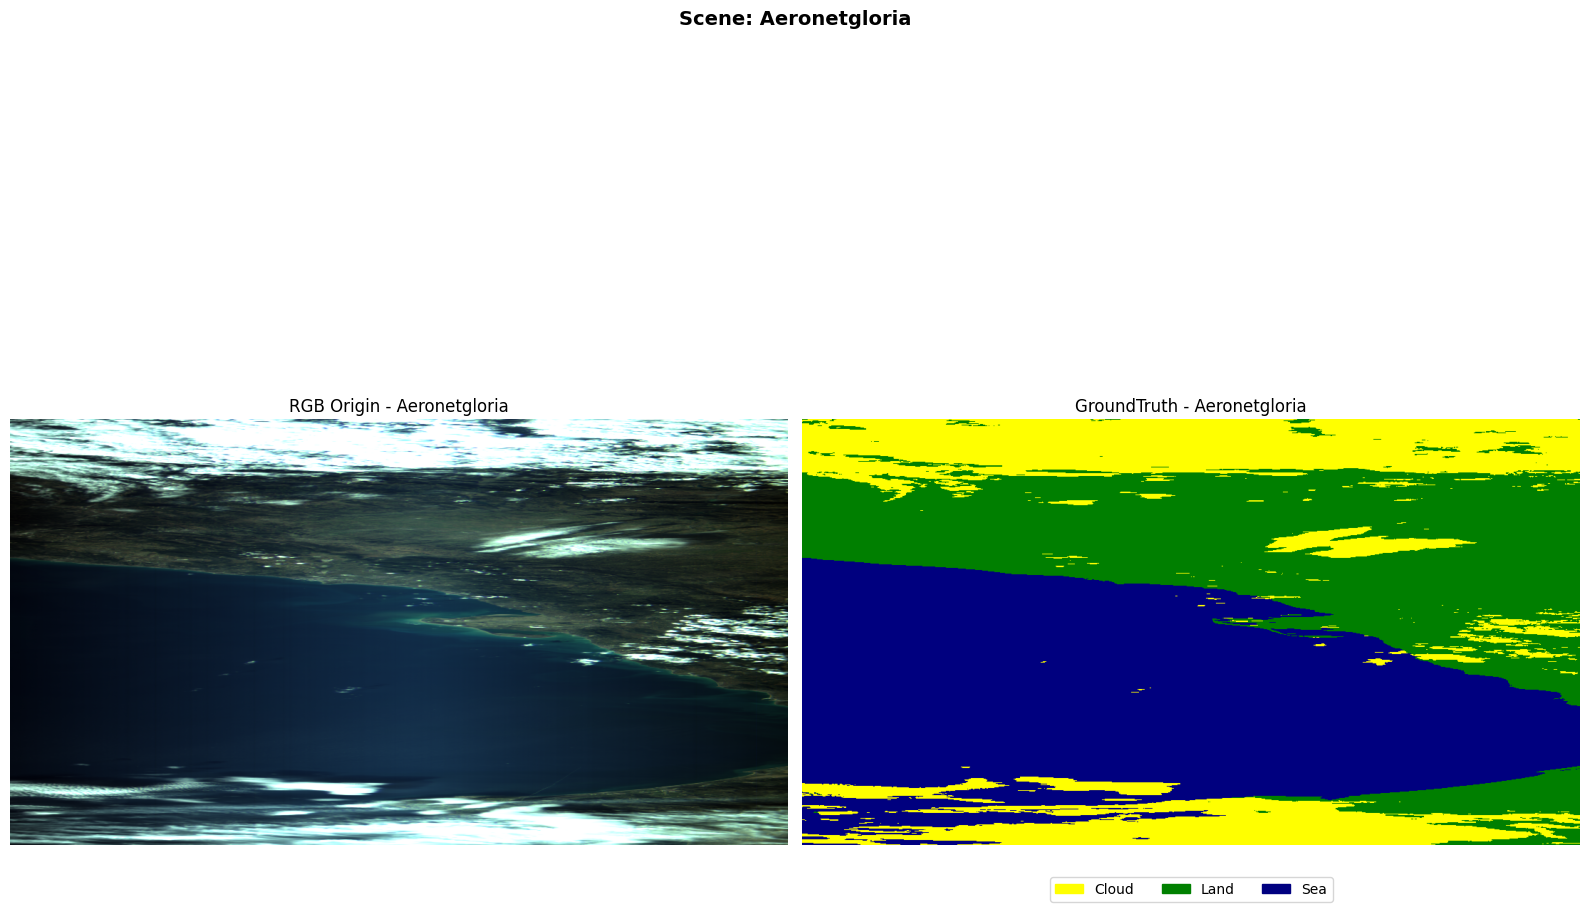

In [10]:
# Select which index of capture in list to plot
#capture = int(input("Select capture: "))
capture = int(1)

if data_file == 'h2':
    hyperspectral_data = h2_files[capture]
    label = labels[capture]
    scene_name = hypso2_files[capture].split("_")[0]
    
# Check the number of unique classes in the label
unique_labels = np.unique(label)
num_classes = len(unique_labels)

# Class names and color maps based on the number of classes in labels
if num_classes == 4:
    class_names = {1: "Snow", 2: "Cloud", 3: "Land", 4: "Sea"}
    color_map = {
        1: (1, 1, 1),      # Snow (white)
        2: (1, 1, 0),      # Cloud (yellow)
        3: (0, 0.5, 0),    # Land (dark green)
        4: (0, 0, 0.5)     # Sea (dark blue)
    }
elif num_classes == 3:
    class_names = {1: "Cloud", 2: "Land", 3: "Sea"}
    color_map = {
        1: (1, 1, 0),      # Cloud (yellow)
        2: (0, 0.5, 0),    # Land (dark green)
        3: (0, 0, 0.5)     # Sea (dark blue)
    }
else:
    print(f"Unexpected number of classes ({num_classes}) in label.")
    exit()

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Generate RGB image
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Create legend
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]

axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Apply Transformations

In [11]:
if apply_pca:
    PROCESSING_TYPE = "pca"
    processed_images = batch_processing(
        files=h2_files,
        num_pca_components=N_PCA,
        batch_size=BATCH_SIZE,
        processing_type=PROCESSING_TYPE
    )
    print(processed_images.shape)

## Data Split

In [12]:
RANDOM_SEED= 4
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




if apply_pca:
    print('Splitting processed images')
    data = processed_images
    data_labels = labels
    data_filenames = h2_filenames
    data_label_filenames = label_filenames
else:
    print('Splitting images (No pre-processing)')
    data = h2_files
    data_labels = labels
    data_filenames = h2_filenames
    data_label_filenames = label_filenames

# Split into training and validation + testing
train_images, temp_images, train_labels, temp_labels, train_filenames, temp_filenames, train_label_filenames, temp_label_filenames = train_test_split(
    data, data_labels, data_filenames, data_label_filenames,
    test_size=1 - TRAIN_SIZE, random_state=RANDOM_SEED
)

# Split into validation and testing
val_images, testing_files, val_labels, testing_labels, val_filenames, testing_filenames, val_label_filenames, testing_label_filenames = train_test_split(
    temp_images, temp_labels, temp_filenames, temp_label_filenames,
    test_size=TEST_SIZE / (VALIDATION_SIZE + TEST_SIZE), random_state=RANDOM_SEED
)

train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)
test_data = TestPatchSet(testing_files, TEST_PATCH_SIZE, TEST_STRIDE)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders ready✅")
print(f" Training images: {len(train_images)}")
print(f" Validation images: {len(val_images)}")
print(f" Testing images: {len(testing_files)}")

for scenes in train_filenames:
    print(f"Training Scenes: {scenes}")

for scenes in val_filenames:
    print(f"Validation Scenes: {scenes}")

for scenes in testing_filenames:
    print(f"Testing Scenes: {scenes}")    

Splitting images (No pre-processing)
DataLoaders ready✅
 Training images: 18
 Validation images: 6
 Testing images: 6
Training Scenes: frohavet_2025-02-25T11-26-39Z-l1a.nc
Training Scenes: ariake_2025-02-11T02-05-25Z-l1a.nc
Training Scenes: goddard_2025-01-09T16-07-16Z-l1a.nc
Training Scenes: aquawatchgrippsland_2025-03-09T00-16-17Z-l1a.nc
Training Scenes: aquawatchmoreton_2025-01-22T00-11-33Z-l1a.nc
Training Scenes: moby_2025-01-08T20-54-59Z-l1a.nc
Training Scenes: grizzlybay_2025-01-22T19-11-18Z-l1a.nc
Training Scenes: blanca_2025-02-04T14-31-12Z-l1a.nc
Training Scenes: falklandsatlantic_2025-03-03T14-11-51Z-l1a.nc
Training Scenes: image65N10E_2025-03-12T11-20-52Z-l1a.nc
Training Scenes: sanjorgegulf_2025-03-08T14-39-52Z-l1a.nc
Training Scenes: timaru_2025-01-21T22-39-53Z-l1a.nc
Training Scenes: bluenile_2025-01-25T08-23-16Z-l1a.nc
Training Scenes: aeronetgloria_2025-01-09T11-17-15Z-l1a.nc
Training Scenes: aquawatchspencer_2025-01-03T01-17-50Z-l1a.nc
Training Scenes: mvco_2025-02-05T

## Model

In [13]:

class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=DWT_WAVELET_LEVELS, base_channels=BASE_CHANNELS, dropout_rate=DROPOUT_RATE):
   
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave=MOTHER_WAVELET) for _ in range(levels)])
        
        # Projection and convolution blocks
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        # Keep track of output channels for each level
        self.level_channels = []
        
        for i in range(levels):
            # Calculate previous channels for feature concatenation
            prev_channels_sum = sum(self.level_channels)
            
            # Input channels include the low-pass and high-pass wavelet coefficients plus previous features
            input_channels = in_channels + 3 * in_channels + prev_channels_sum
            
            # Exponential scaling: base_channels * 2^i
            output_channels = base_channels * (2 ** i)
            self.level_channels.append(output_channels)

            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Dropout(p=dropout_rate)
            ))

        # Segmentation Head
        total_channels = sum(self.level_channels)
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(total_channels // 2, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2), 
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

        # Dynamic upsampling layers
        self.upsample_layers = nn.ModuleList()
        current_channels = total_channels // 2
        
        # Create upsampling layers based on levels
        for i in range(levels):
            out_channels = current_channels // 2 if i < levels - 1 else class_nums
            self.upsample_layers.append(
                nn.ConvTranspose2d(current_channels, out_channels, kernel_size=2, stride=2)
            )
            current_channels = out_channels

    def forward(self, x):
        features = []
        low_pass = x
        
        # Wavelet processing
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)

        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)

        # Dynamic upsampling based on number of levels
        for upsample_layer in self.upsample_layers:
            out = upsample_layer(out)
            # Need this line if wavelets are other than 'db1' or 'haar', but works for 'db1' and 'haar' aswell
            out = F.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)

        return out



# Initialize the model:

net = WaveletCNN(in_channels=num_components , class_nums=NUM_CLASS)
input_tensor = torch.randn(1, num_components,PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary:
summary(
    net,
    input_size=(1, num_components, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 120, 16, 16])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 120, 16, 16]   [1, 3, 16, 16]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 120, 16, 16]   [1, 120, 10, 10]
├─ModuleList (projections)               --                 --                 --                 --                 --
│    └─Conv2d (0)                        7,696              [1, 1]             769,600            [1, 480, 10, 10]   [1, 16, 10, 10]
├─ModuleList (conv_blocks)               --                 --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 16, 10, 1

## Training

Using device: cuda


Training::   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 1/10 | Train Acc: 0.9204 | Val Acc: 0.9632 | Val IoU: 0.9096 | LR: 0.000500 | Time: 104.94s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 2/10 | Train Acc: 0.9350 | Val Acc: 0.9642 | Val IoU: 0.9105 | LR: 0.000500 | Time: 106.86s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 3/10 | Train Acc: 0.9378 | Val Acc: 0.9753 | Val IoU: 0.9373 | LR: 0.000500 | Time: 106.64s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 4/10 | Train Acc: 0.9396 | Val Acc: 0.9732 | Val IoU: 0.9330 | LR: 0.000500 | Time: 106.94s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 5/10 | Train Acc: 0.9414 | Val Acc: 0.9662 | Val IoU: 0.9176 | LR: 0.000500 | Time: 108.38s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 6/10 | Train Acc: 0.9426 | Val Acc: 0.9703 | Val IoU: 0.9261 | LR: 0.000500 | Time: 106.45s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 7/10 | Train Acc: 0.9433 | Val Acc: 0.9774 | Val IoU: 0.9419 | LR: 0.000500 | Time: 106.39s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 8/10 | Train Acc: 0.9440 | Val Acc: 0.9688 | Val IoU: 0.9218 | LR: 0.000500 | Time: 106.38s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 9/10 | Train Acc: 0.9444 | Val Acc: 0.9609 | Val IoU: 0.9041 | LR: 0.000500 | Time: 106.50s


Train Batch:   0%|          | 0/5544 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1848 [00:00<?, ?it/s]

Epoch 10/10 | Train Acc: 0.9447 | Val Acc: 0.9729 | Val IoU: 0.9320 | LR: 0.000500 | Time: 106.09s
🏁 Training completed in 1065.62 seconds.
🛑 Stopped at epoch 10
best model:21_03_20_38_acc_0.9774_EPOCH_6.pth


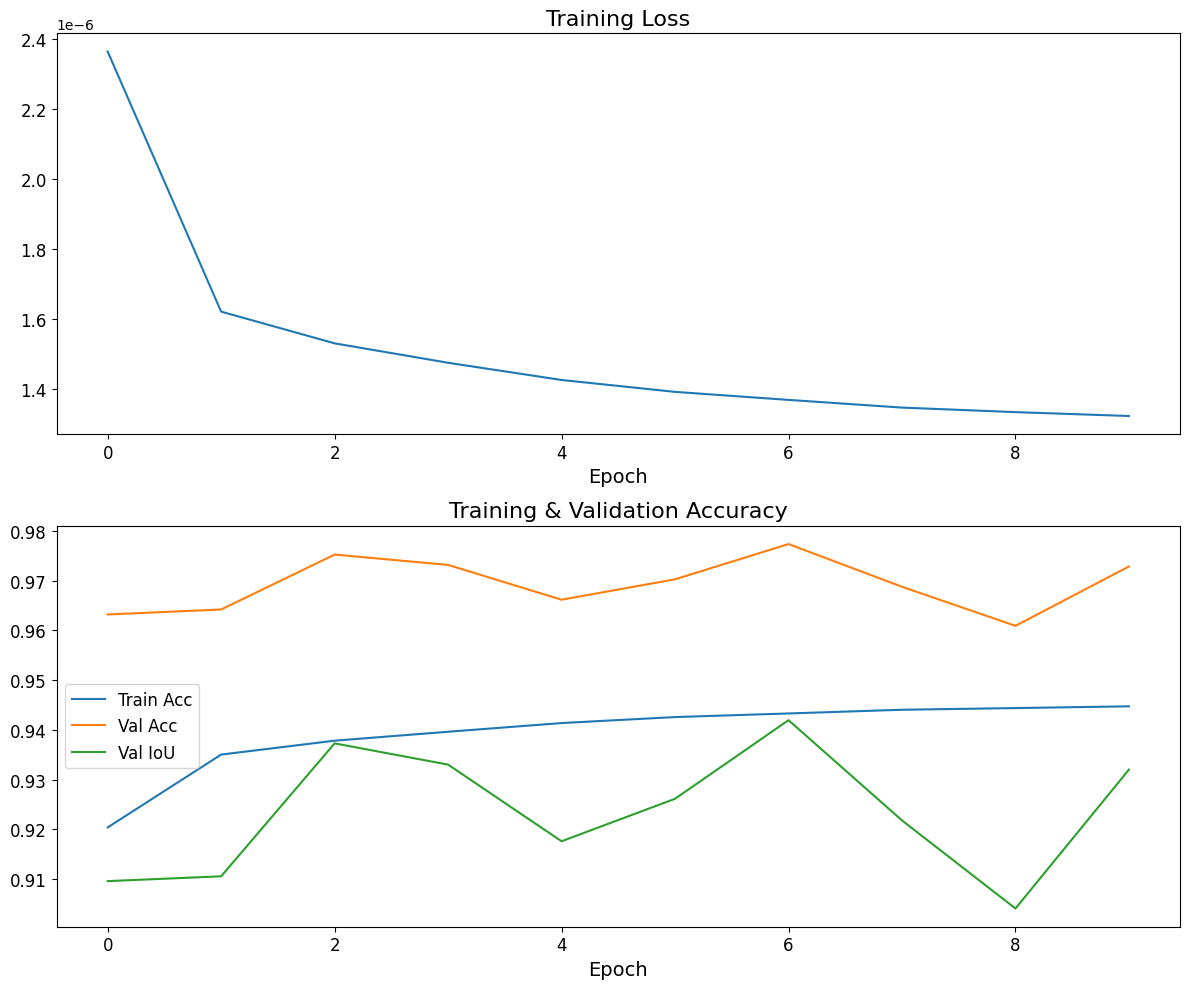

🎯 Best model retained: results\h2\21_03_20_38_acc_0.9774_EPOCH_6.pth


In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")

model = WaveletCNN(num_components, class_nums=NUM_CLASS).to(device)

#optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


loss_func = FocalLoss(alpha=1, gamma=2)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

loss_list, acc_list, val_acc_list, val_dice_list, val_iou_list, val_epoch_list = [], [], [], [], [], []
best_val_acc = 0.0
patience = 20


train_num = len(train_loader.dataset) * PATCH_SIZE * PATCH_SIZE
val_num = len(val_loader.dataset) * PATCH_SIZE * PATCH_SIZE
start_time = time.time()

# Initialize training log
training_log = []

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.0
        train_acc = 0

        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Train Batch", leave=False)
        for batch_idx, (data, target) in train_progress:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1
            loss = loss_func(out, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _, pred = torch.max(out, dim=1)
            train_acc += (pred == target).sum().item()
            train_progress.set_postfix({"Loss": loss.item()})

        loss_list.append(avg_loss / float(train_num))
        acc_list.append(train_acc / train_num)

        model.eval()
        val_acc = 0
        val_dice = 0.0
        val_iou = 0.0
        val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Batch", leave=False)
        with torch.no_grad():
            for batch_idx, (data, target) in val_progress:
                data, target = data.to(device), target.to(device)
                out = model(data)
                target = target - 1
                _, pred = torch.max(out, dim=1)
                val_acc += (pred == target).sum().item()

                dice_score = dice(pred, target)
                iou_score = jaccard_index(pred, target, task='multiclass', num_classes=NUM_CLASS)

                val_dice += dice_score.item()
                val_iou += iou_score.item()

        val_acc /= val_num
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)

        val_acc_list.append(val_acc)
        val_dice_list.append(val_dice)
        val_iou_list.append(val_iou)
        val_epoch_list.append(e)

        scheduler.step(val_acc_list[-1])
        current_lr = optimizer.param_groups[0]['lr']

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        epoch_output = f"Epoch {e + 1}/{EPOCH} | Train Acc: {acc_list[-1]:.4f} | Val Acc: {val_acc:.4f} | Val IoU: {val_iou:.4f} | LR: {current_lr:.6f} | Time: {epoch_time:.2f}s"
        print(epoch_output)
        training_log.append(epoch_output) 

        # --- Model saving after each epoch ---
        now = datetime.now()
        date_time_str = now.strftime("%d_%m_%H_%M")
        save_name = os.path.join(SAVE_PATH, f"{date_time_str}_acc_{val_acc:.4f}.pth")
        torch.save(model.state_dict(), save_name)
        # --- End of model saving ---

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            best_model_epoch = e  # Keep track of the best epoch
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            stop_message = f"⏹️ Early stopping triggered at epoch {e + 1}. Best val_acc: {best_val_acc:.4f}"
            print(stop_message)
            training_log.append(stop_message)  # Append early stopping message
            break

except Exception as exc:
    error_message = f"⚠️ Training interrupted: {exc}"
    print(error_message)
    training_log.append(error_message)  # Append error message
finally:
    total_time = time.time() - start_time
    completion_message = f"🏁 Training completed in {total_time:.2f} seconds."
    print(completion_message)
    training_log.append(completion_message)  # Append completion message
    stop_epoch_message = f"🛑 Stopped at epoch {e + 1}"
    print(stop_epoch_message)
    training_log.append(stop_epoch_message)  # Append stop epoch message

    best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
    training_log.append(f"Best model retained: {best_model_path}")  # Append best model path

    # Save the *best* model
    best_model_path = os.path.join(SAVE_PATH, f"{date_time_str}_acc_{best_val_acc:.4f}_EPOCH_{best_model_epoch}.pth")
    torch.save(model.state_dict(), best_model_path)

    # Save training information
    configs = get_configurations()
    save_training_info(model, configs, training_log, best_val_acc)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))  
    ax1.plot(np.arange(len(loss_list)), loss_list, label="Training Loss")
    ax1.set_title("Training Loss", fontsize=16) 
    ax1.set_xlabel("Epoch", fontsize=14)  
    ax1.tick_params(axis='both', labelsize=12) 
    ax2.plot(np.arange(len(acc_list)), acc_list, label="Train Acc")
    ax2.plot(val_epoch_list, val_acc_list, label="Val Acc")
    ax2.plot(val_epoch_list, val_iou_list, label="Val IoU")
    ax2.set_title("Training & Validation Accuracy", fontsize=16)  
    ax2.set_xlabel("Epoch", fontsize=14) 
    ax2.legend(fontsize=12) 
    ax2.tick_params(axis='both', labelsize=12) 
    plt.subplots_adjust(hspace=0.5) 
    plt.tight_layout()  

    # Save the plot with the same name as the best model
    experiments_dir = "C:\\WaveSeg\\experiments"
    if not os.path.exists(experiments_dir):
        os.makedirs(experiments_dir)

    plot_filename = os.path.basename(best_model_path).replace(".pth", ".png")
    plot_path = os.path.join(experiments_dir, plot_filename)
    plt.savefig(plot_path)

    plt.show()

print(f"🎯 Best model retained: {best_model_path}")



### Inference and Evaluation

best model:21_03_20_38_acc_0.9774_EPOCH_6.pth
Loading model from: results\h2\21_03_20_38_acc_0.9774_EPOCH_6.pth
Model loaded

Processing Test Image 1/6 - Scene: gulfofcampeche_2025-03-03T17-04-38Z
Unique classes in ground truth before plotting: [1 2 3]


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_12176\2139849268.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_mode

Predicting Image 1:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


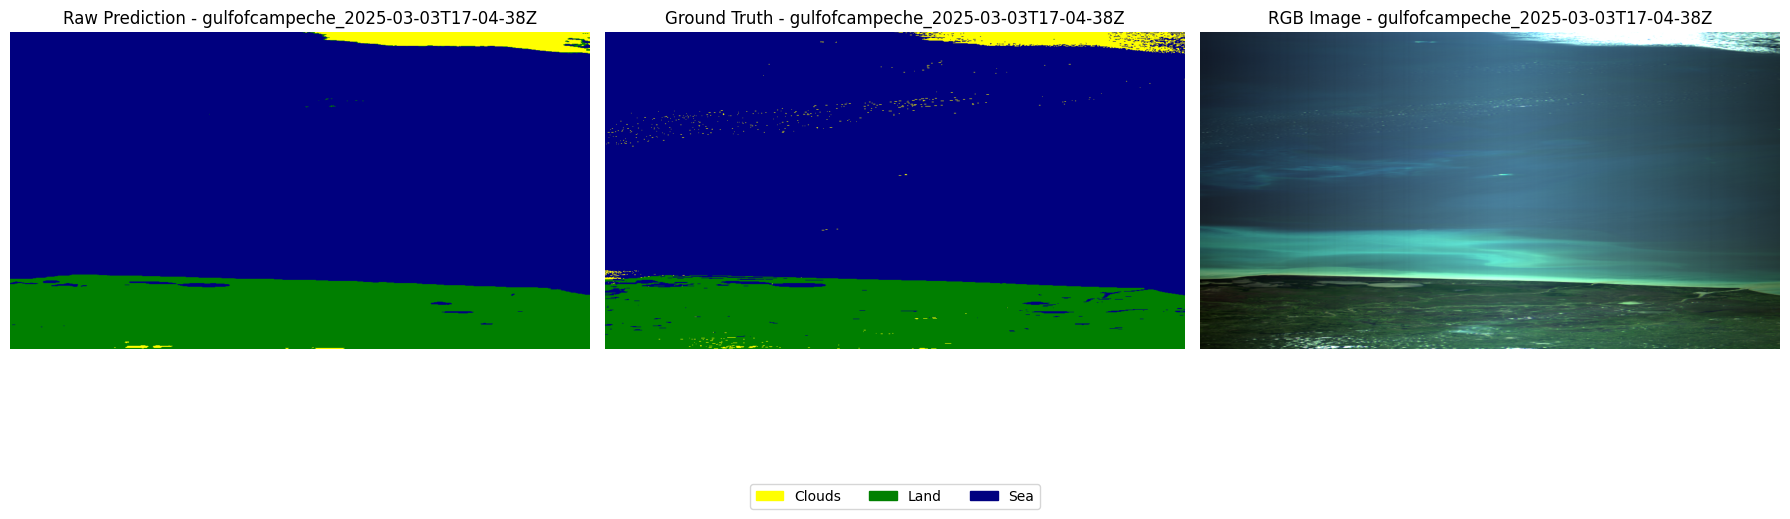

Scene: gulfofcampeche_2025-03-03T17-04-38Z
OA: 0.9883188160780134
AA: 0.9573154391713133
Kappa: 0.9678535120551625
              precision    recall  f1-score   support

      Clouds     0.8570    0.8857    0.8711     14078
        Land     0.9683    0.9975    0.9827    133879
         Sea     0.9977    0.9887    0.9932    505059

    accuracy                         0.9883    653016
   macro avg     0.9410    0.9573    0.9490    653016
weighted avg     0.9886    0.9883    0.9884    653016


Processing Test Image 2/6 - Scene: lacrau_2024-12-26T11-15-54Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


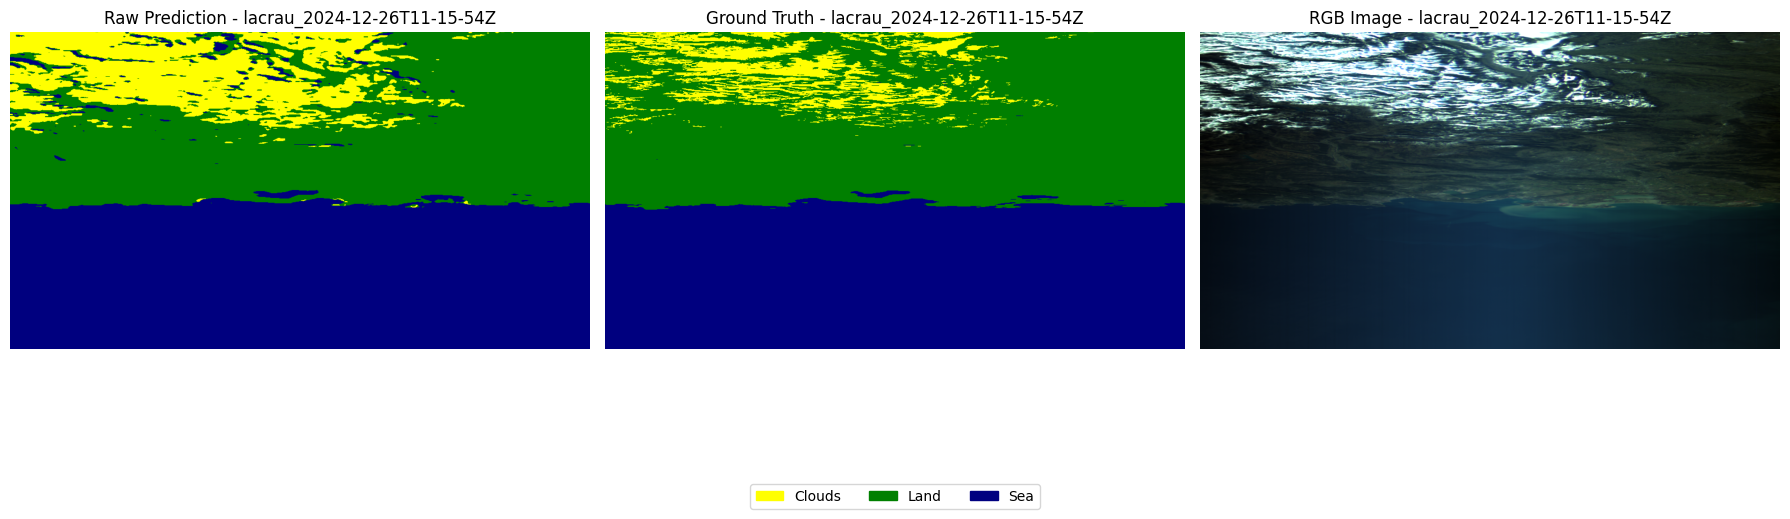

Scene: lacrau_2024-12-26T11-15-54Z
OA: 0.9211780415793793
AA: 0.9439371490453117
Kappa: 0.8663112284643149
              precision    recall  f1-score   support

      Clouds     0.5228    0.9984    0.6862     46443
        Land     0.9996    0.8336    0.9091    308468
         Sea     0.9706    0.9998    0.9850    298105

    accuracy                         0.9212    653016
   macro avg     0.8310    0.9439    0.8601    653016
weighted avg     0.9524    0.9212    0.9279    653016


Processing Test Image 3/6 - Scene: image61N6E_2025-03-13T11-27-56Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 3:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


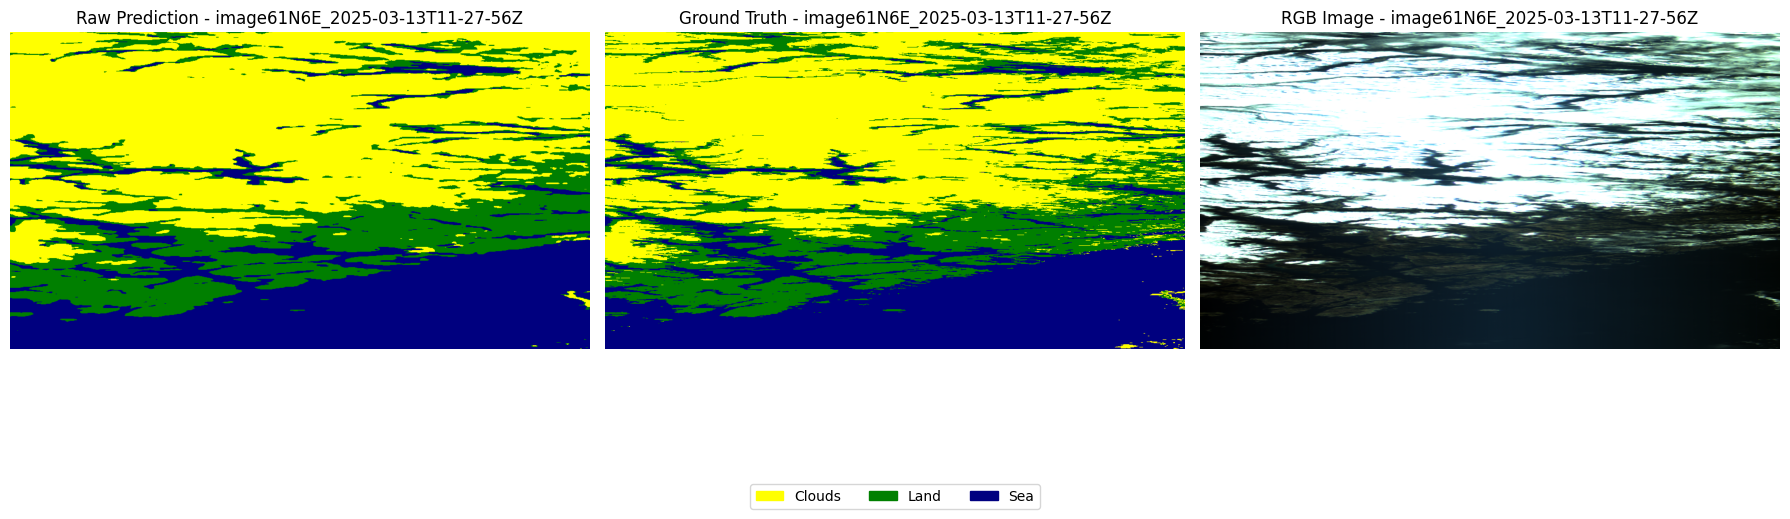

Scene: image61N6E_2025-03-13T11-27-56Z
OA: 0.9230845798571551
AA: 0.9107481567263788
Kappa: 0.8796120120482315
              precision    recall  f1-score   support

      Clouds     0.9210    0.9704    0.9451    298338
        Land     0.8796    0.8225    0.8501    170172
         Sea     0.9652    0.9393    0.9521    184506

    accuracy                         0.9231    653016
   macro avg     0.9219    0.9107    0.9158    653016
weighted avg     0.9227    0.9231    0.9223    653016


Processing Test Image 4/6 - Scene: aeronetgalata_2025-01-02T08-52-34Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 4:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


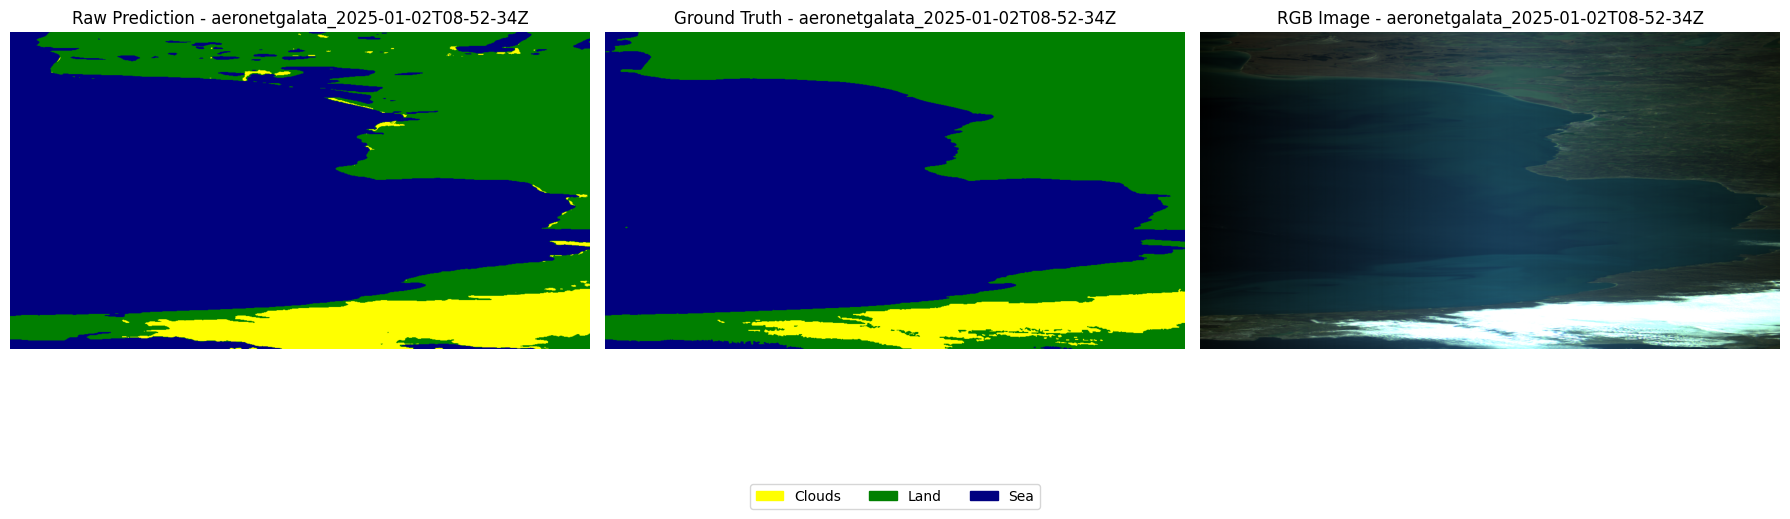

Scene: aeronetgalata_2025-01-02T08-52-34Z
OA: 0.9291135286118564
AA: 0.9388829701388275
Kappa: 0.8712710406142168
              precision    recall  f1-score   support

      Clouds     0.7121    1.0000    0.8318     44577
        Land     1.0000    0.8167    0.8991    252511
         Sea     0.9264    1.0000    0.9618    355928

    accuracy                         0.9291    653016
   macro avg     0.8795    0.9389    0.8976    653016
weighted avg     0.9402    0.9291    0.9287    653016


Processing Test Image 5/6 - Scene: kemigawa_2025-01-22T01-31-13Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 5:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


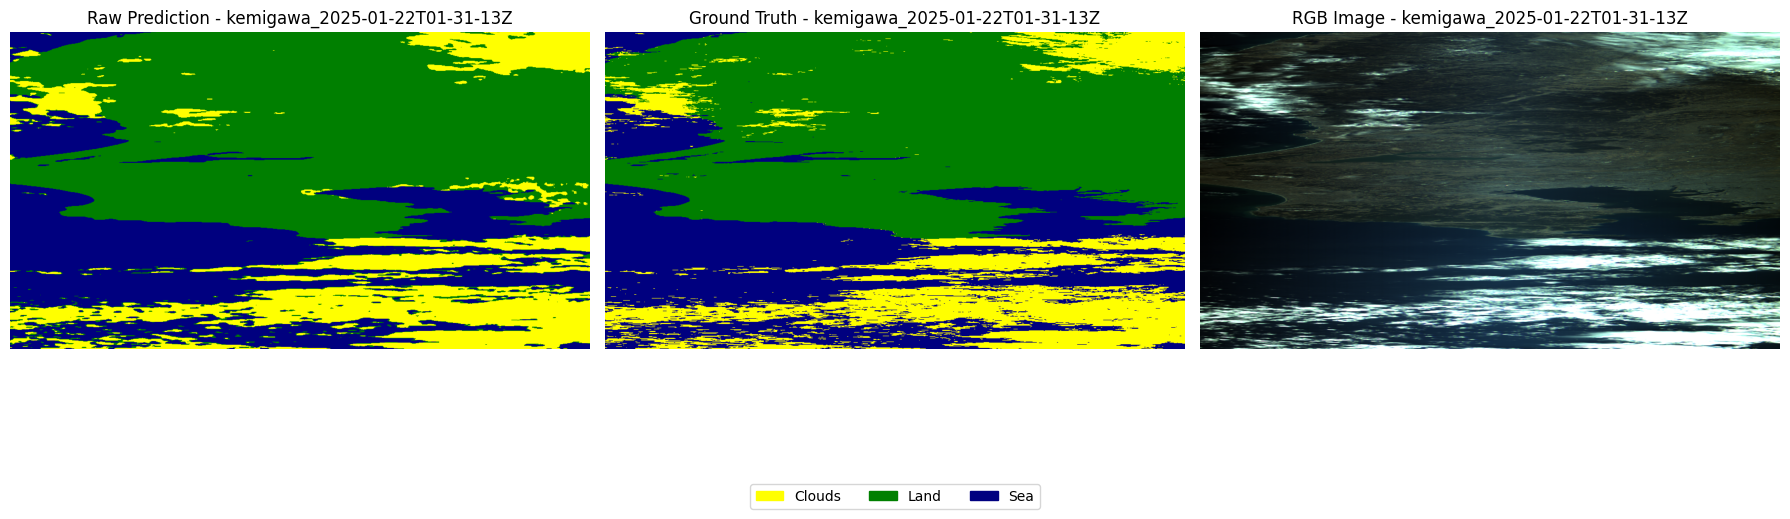

Scene: kemigawa_2025-01-22T01-31-13Z
OA: 0.9441055043061732
AA: 0.9322258938794166
Kappa: 0.9097449152459498
              precision    recall  f1-score   support

      Clouds     0.9056    0.8950    0.9003    130313
        Land     0.9386    0.9749    0.9564    321172
         Sea     0.9799    0.9267    0.9525    201531

    accuracy                         0.9441    653016
   macro avg     0.9413    0.9322    0.9364    653016
weighted avg     0.9447    0.9441    0.9440    653016


Processing Test Image 6/6 - Scene: wilmington_2025-03-08T15-55-06Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 6:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


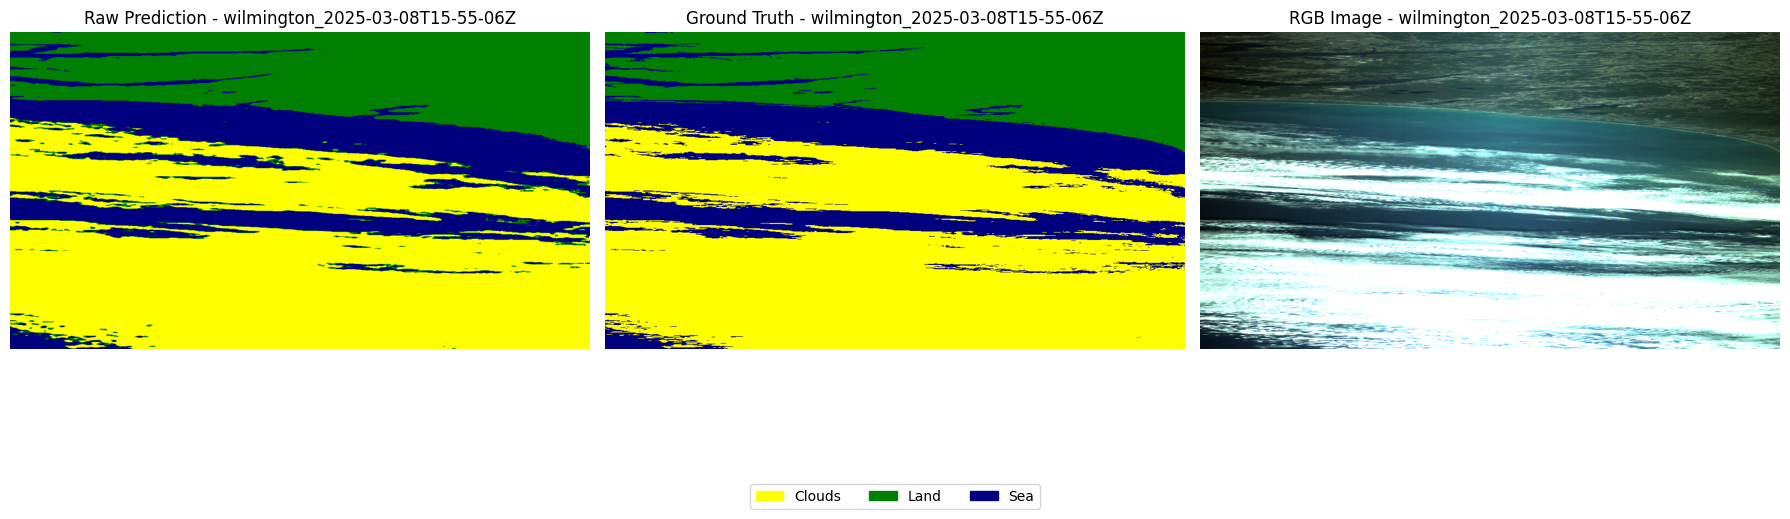

Scene: wilmington_2025-03-08T15-55-06Z
OA: 0.9464377595648499
AA: 0.9445634765538627
Kappa: 0.9128321166934521
              precision    recall  f1-score   support

      Clouds     0.9865    0.9467    0.9662    345642
        Land     0.8949    0.9862    0.9383    163245
         Sea     0.9182    0.9008    0.9094    144129

    accuracy                         0.9464    653016
   macro avg     0.9332    0.9446    0.9380    653016
weighted avg     0.9485    0.9464    0.9467    653016



In [15]:
# Class mapping
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),  # Clouds (yellow)
    2: (0, 0.5, 0),  # Land (dark green)
    3: (0, 0, 0.5),  # Sea (dark blue)
}
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

testing_label_dict = {
    os.path.basename(fname).replace("-l1a_labels.dat", ""): label
    for fname, label in zip(testing_label_filenames, testing_labels)
}

# Load trained model
best_model_path = trained_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"Loading model from: {best_model_path}")

best_model = WaveletCNN(num_components, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  

print("Model loaded")

# Store predictions for generating .dat files
all_predictions = {}

for img_idx, test_img_filename in enumerate(testing_filenames):
    scene_name = os.path.basename(test_img_filename).replace("-l1a.nc", "")  
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]
    else:
        print(f"Warning: No matching ground truth found for {scene_name}")
        continue

    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    test_img = testing_files[img_idx]

    test_data = TestPatchSet([test_img], patch_size=16, stride=2)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    pred_patches = []
    confidence_scores = []

    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)

        out = best_model(data)
        probs = F.softmax(out, dim=1)

        max_probs, pred = torch.max(probs, dim=1)

        pred_patches.append(pred.detach().cpu().numpy())
        confidence_scores.append(max_probs.detach().cpu().numpy())

    pred_patches = np.concatenate(pred_patches, axis=0)
    confidence_scores = np.concatenate(confidence_scores, axis=0)

    original_shape = test_img.shape[:2]

    pred_map = reconstruct_image_with_confidence(
        pred_patches,
        confidence_scores,
        original_shape,
        patch_size=16,
        stride=2,
    )

    print(f"Unique classes in prediction: {np.unique(pred_map)}")

    # Store the prediction
    all_predictions[scene_name] = pred_map

    # Match scene name to corresponding L1D file using reflectance_data_files
    matching_h2_file = None
    if scene_name in [os.path.basename(file).replace('-l1a.nc', '') for file in hypso2_files]:
        for hypso2_file in hypso2_files:
            if scene_name in hypso2_file:
                matching_h2_file = load_l1a_nc_cube(os.path.join(hypso2_data_path, hypso2_file))
                break

    if matching_h2_file is not None:
        hyperspectral_data = matching_h2_file
        rgb_image = spectral.get_rgb(hyperspectral_data, (69, 46, 26))
    else:
        print(f"Warning: No matching L1D file found for {scene_name}, skipping RGB plot.")
        rgb_image = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3))  # Placeholder black image

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Raw Prediction - {scene_name}')
    axes[0].axis("off")

    axes[1].imshow(ground_truth, cmap=custom_cmap)
    axes[1].set_title(f'Ground Truth - {scene_name}')
    axes[1].axis("off")

    axes[2].imshow(rgb_image)
    axes[2].set_title(f'RGB Image - {scene_name}')
    axes[2].axis("off")

    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Evaluation for each image
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    # Adjust predictions to match ground truth labels (1, 2, 3)
    test_pred = test_pred + 1
    
    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)
    report_log = f"Scene: {scene_name}\nOA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
    report_log += classification_report(test_true, test_pred, target_names=[class_names[i] for i in sorted(class_names.keys())], digits=4, zero_division=0, labels=sorted(class_names.keys()))
    print(report_log)

In [16]:
output_dir = "predictions"  # Create a directory for prediction files
os.makedirs(output_dir, exist_ok=True)

first_prediction_filename = None  # Store the name of the first file

for scene_name, pred_map in all_predictions.items():
    prediction_filename = os.path.join(output_dir, f"{scene_name}.dat")
    pred_map = pred_map.astype(np.uint8)  # Ensure dat file is saved as uint8
    pred_map = pred_map + 1  # If you want your prediction to be 1, 2, 3 instead of 0, 1, 2.
    pred_map.tofile(prediction_filename)
    print(f"Prediction saved to: {prediction_filename}")

Prediction saved to: predictions\gulfofcampeche_2025-03-03T17-04-38Z.dat
Prediction saved to: predictions\lacrau_2024-12-26T11-15-54Z.dat
Prediction saved to: predictions\image61N6E_2025-03-13T11-27-56Z.dat
Prediction saved to: predictions\aeronetgalata_2025-01-02T08-52-34Z.dat
Prediction saved to: predictions\kemigawa_2025-01-22T01-31-13Z.dat
Prediction saved to: predictions\wilmington_2025-03-08T15-55-06Z.dat
